### July 13, 2015

####A brief attempt at a bayesian tutorial for my dad.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pymc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


For this we are going to use a simple example from this website: http://sabermetricinsights.blogspot.com/2014/05/bayesian-linear-regression-with-pymc.html


We're going to try to model the mpg of a car as a function of the car's weight, i.e., 
$$mpg = b0 + b1 * weight + error$$

In [10]:
cars_data =  ({"weight": [ 4.36, 4.054, 3.605, 3.94, 2.155, 2.56, 2.3, 2.23, 2.83, 3.14, 2.795,
               3.41, 3.38, 3.07, 3.62, 3.41, 3.84, 3.725, 3.955, 3.83, 2.585, 2.91, 
               1.975, 1.915, 2.67, 1.99, 2.135, 2.67, 2.595, 2.7, 2.556, 2.2, 2.02,
               2.13, 2.19, 2.815, 2.6],
              "mpg": [16.9, 15.5, 19.2, 18.5, 30, 27.5, 27.2, 30.9, 20.3, 19.5, 21.6, 16.2, 
               20.6, 20.8, 18.6, 18.1, 17, 17.6, 16.5, 18.2, 26.5, 21.9, 34.1, 35.1, 
               27.4, 31.5, 29.5, 28.4, 28.8, 26.8, 33.5, 34.2, 31.8, 37.3, 30.5, 22, 21.5]})

In [11]:
# NOTE: the linear regression model we're trying to solve for is 
# given by:
# y = b0 + b1(x) + error
# where b0 is the intercept term, b1 is the slope, and error is 
# the error

# model the intercept/slope terms of our model as 
# normal random variables with comically large variances
b0 = pymc.Normal("b0", 0, 0.0003)
b1 = pymc.Normal("b1", 0, 0.0003)

# model our error term as a uniform random variable
err = pymc.Uniform("err", 0, 500)


# "model" the observed x values as a normal random variable
# in reality, because x is observed, it doesn't actually matter
# how we choose to model x -- PyMC isn't going to change x's values
x_weight = pymc.Normal("weight", 0, 1, value=np.array(cars_data["weight"]), observed=True)

# this is the heart of our model: given our b0, b1 and our x observations, we want
# to predict y
@pymc.deterministic
def pred(b0=b0, b1=b1, x=x_weight):
    return b0 + b1*x

# "model" the observed y values: again, I reiterate that PyMC treats y as 
# evidence -- as fixed; it's going to use this as evidence in updating our belief
# about the "unobserved" parameters (b0, b1, and err), which are the 
# things we're interested in inferring after all
y = pymc.Normal("y", pred, err, value=np.array(cars_data["mpg"]), observed=True)

# put everything we've modeled into a PyMC model
model = pymc.Model([pred, b0, b1, y, err, x_weight])

In [12]:
#This requires installing some things so we won't worry about it for now.
#import pymc.graph
#graph = pymc.graph.graph(model)
#graph.write_png('univariate.png')

In [13]:
# prepare for MCMC
mcmc = pymc.MCMC(model)

# sample from our posterior distribution 50,000 times, but
# throw the first 20,000 samples out to ensure that we're only
# sampling from our steady-state posterior distribution
mcmc.sample(50000, 20000)

 [-----------------100%-----------------] 50000 of 50000 complete in 4.6 sec

-8.48565608161


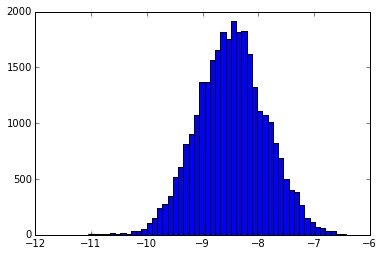

In [15]:
print np.mean(mcmc.trace('b1')[:])
plt.hist(mcmc.trace('b1')[:], bins=50);